In [1]:
%load_ext watermark


In [2]:
import os

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp

import pylib  # noqa: F401


In [3]:
%watermark -diwmuv -iv


Last updated: 2026-02-04T15:35:43.363151+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1044-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

pandas    : 2.2.3
seaborn   : 0.13.2
teeplot   : 1.1.3
pylib     : 0.0.0
matplotlib: 3.9.2
numpy     : 2.1.2

Watermark: 2.4.3



In [4]:
teeplot_subdir = os.environ.get("NOTEBOOK_NAME", None)
teeplot_subdir


'2025-02-04-mutant-ratio-derivation'

# Derivation of Mutant Ratio ($y/x$)


### 1. Assumptions and System Setup

We assume a growth period of $T = 25$ "doublings" and an initial wild-type population $X_0 = 1$.

The system is defined by the following differential equations:

$$
\frac{dx}{dt} = X
$$

$$
\frac{dy}{dt} = mX + by
$$


### 2. Solve for $X$

Since $\frac{dx}{dt} = X$ and $X_0 = 1$, the solution describes simple exponential growth:

$$
X(t) = e^t
$$


### 3. Solve for $y$

Substitute $X = e^t$ into the equation for $y$:

$$
\frac{dy}{dt} = m e^t + by
$$

Using the integrating factor method for a linear first-order ODE (where $b \neq 1$), the general solution is:

$$
y(t) = \frac{m}{1-b}e^t + C e^{bt}
$$


### 4. Apply Initial Conditions

Assume initially there are no mutants, so $y(0) = 0$.

$$
0 = \frac{m}{1-b}e^0 + C e^0 \implies C = - \frac{m}{1-b}
$$

Substituting $C$ back into the general solution:

$$
y(t) = \frac{m}{1-b}e^t - \frac{m}{1-b}e^{bt}
$$

$$
y(t) = \frac{m}{1-b} \left( e^t - e^{bt} \right)
$$


### 5. Calculate the Ratio $y/x$

We define the mutant fraction as $y/x$. Dividing the expression for $y(t)$ by $X(t) = e^t$:

$$
\frac{y}{x} = \frac{\frac{m}{1-b} (e^t - e^{bt})}{e^t}
$$

$$
\frac{y}{x} = \frac{m}{1-b} (1 - e^{(b-1)t})
$$


### 6. Final Rearrangement (for $b > 1$)

Given the parameters $m = 1 \times 10^{-6}$ and $b = 1.1$ (where $b > 1$):
We flip the sign of the denominator ($1-b \to b-1$) and the term inside the parentheses to handle the positive growth rates.

$$
\frac{y}{x} = \frac{m}{b-1} \left( e^{(b-1)t} - 1 \right)
$$


## Implementation


In [5]:
def calc_mutant_ratio(
    t: np.ndarray,
    b: np.ndarray,
    m: float,
) -> np.ndarray:
    """Calculate the mutant ratio y/x for given parameters.

    Vectorized calculation supporting arrays for t and b.
    Uses masking to handle the special case where b == 1.

    Parameters
    ----------
    t : np.ndarray
        Time values (number of doublings).
    b : np.ndarray
        Relative growth rate of mutant vs wild-type.
        b > 1 means mutant grows faster, b < 1 means slower.
    m : float
        Mutation rate (constant).

    Returns
    -------
    np.ndarray
        Mutant ratio y/x at each (t, b) combination.

    Notes
    -----
    For b != 1:
        y/x = m / (1 - b) * (1 - exp((b - 1) * t))

    For b == 1 (limit case via L'Hopital's rule):
        y/x = m * t
    """
    t = np.asarray(t)
    b = np.asarray(b)

    # Use broadcasting to handle array inputs
    # Reshape for proper broadcasting if both are arrays
    if t.ndim > 0 and b.ndim > 0:
        t = t[:, np.newaxis] if t.ndim == 1 else t
        b = b[np.newaxis, :] if b.ndim == 1 else b

    # Create output array
    result = np.empty(np.broadcast(t, b).shape, dtype=np.float64)

    # Mask for b == 1 (special case)
    b_eq_1 = np.isclose(b, 1.0)
    b_ne_1 = ~b_eq_1

    # General case: b != 1
    # y/x = m / (1 - b) * (1 - exp((b - 1) * t))
    if np.any(b_ne_1):
        b_broadcast = np.broadcast_to(b, result.shape)
        t_broadcast = np.broadcast_to(t, result.shape)
        mask = np.broadcast_to(b_ne_1, result.shape)
        b_vals = b_broadcast[mask]
        t_vals = t_broadcast[mask]
        result[mask] = m / (1.0 - b_vals) * (1.0 - np.exp((b_vals - 1.0) * t_vals))

    # Special case: b == 1 (limit as b -> 1)
    # By L'Hopital's rule: y/x = m * t
    if np.any(b_eq_1):
        t_broadcast = np.broadcast_to(t, result.shape)
        mask = np.broadcast_to(b_eq_1, result.shape)
        result[mask] = m * t_broadcast[mask]

    return result


## Verify Implementation


In [6]:
# Test with example values from derivation
t_test = 25.0
b_test = 1.1
m_test = 1e-6

ratio = calc_mutant_ratio(np.array([t_test]), np.array([b_test]), m_test)
print(f"At t={t_test}, b={b_test}, m={m_test}:")
print(f"  y/x = {ratio[0, 0]:.6e}")

# Verify formula manually
expected = m_test / (b_test - 1) * (np.exp((b_test - 1) * t_test) - 1)
print(f"  Expected (manual): {expected:.6e}")


At t=25.0, b=1.1, m=1e-06:
  y/x = 1.118249e-04
  Expected (manual): 1.118249e-04


In [7]:
# Test special case b = 1
ratio_b1 = calc_mutant_ratio(np.array([t_test]), np.array([1.0]), m_test)
print("\nSpecial case b=1:")
print(f"  y/x = {ratio_b1[0, 0]:.6e}")
print(f"  Expected (m*t): {m_test * t_test:.6e}")



Special case b=1:
  y/x = 2.500000e-05
  Expected (m*t): 2.500000e-05


## Visualize y/x Across Parameter Space


In [8]:
# Define parameter ranges
T = 25  # number of doublings
m_values = np.array([1e-8, 1e-7, 1e-6, 1e-5, 1e-4])
b_values = np.linspace(0.5, 2.0, 50)
t_values = np.array([T])


In [9]:
# Build dataframe for visualization
records = []
for m in m_values:
    ratios = calc_mutant_ratio(t_values, b_values, m)
    for i, b in enumerate(b_values):
        records.append({
            "m": m,
            "b": b,
            "y/x": ratios[0, i],
            "m_label": f"m = {m:.0e}",
        })

df = pd.DataFrame(records)
display(df.head()), display(df.tail());


,m,b,y/x,m_label
0,1.000000e-08,0.500000,1.999993e-08,m = 1e-08
1,1.000000e-08,0.530612,2.130418e-08,m = 1e-08
2,1.000000e-08,0.561224,2.279031e-08,m = 1e-08
3,1.000000e-08,0.591837,2.449909e-08,m = 1e-08
4,1.000000e-08,0.622449,2.648438e-08,m = 1e-08


,m,b,y/x,m_label
245,0.0001,1.877551,3.842526e+05,m = 1e-04
246,0.0001,1.908163,7.981664e+05,m = 1e-04
247,0.0001,1.938776,1.659831e+06,m = 1e-04
248,0.0001,1.969388,3.455384e+06,m = 1e-04
249,0.0001,2.000000,7.200490e+06,m = 1e-04


teeplots/2025-02-04-mutant-ratio-derivation/T=25+hue=m-label+kind=line+palette=viridis+viz=relplot+what=mutant-ratio-vs-b+x=b+y=y-x+ext=.pdf
teeplots/2025-02-04-mutant-ratio-derivation/T=25+hue=m-label+kind=line+palette=viridis+viz=relplot+what=mutant-ratio-vs-b+x=b+y=y-x+ext=.png


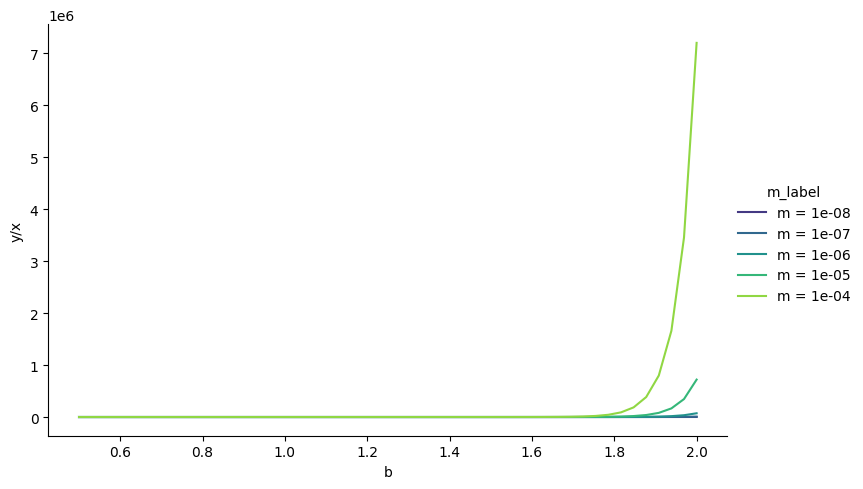

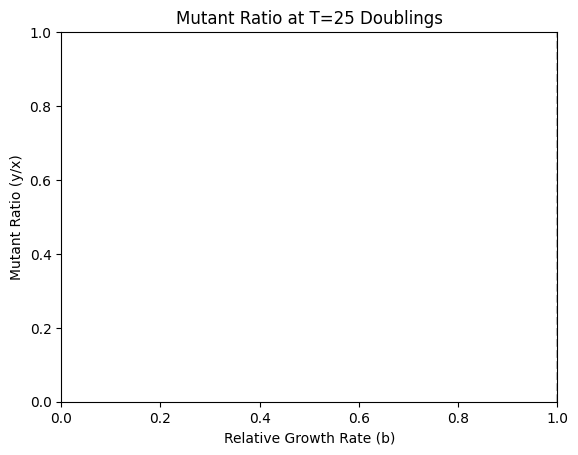

In [10]:
tp.tee(
    sns.relplot,
    data=df,
    x="b",
    y="y/x",
    hue="m_label",
    kind="line",
    aspect=1.5,
    height=5,
    palette="viridis",
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={"what": "mutant-ratio-vs-b", "T": T},
)
plt.axvline(x=1.0, color="gray", linestyle="--", alpha=0.5, label="b=1")
plt.xlabel("Relative Growth Rate (b)")
plt.ylabel("Mutant Ratio (y/x)")
plt.title(f"Mutant Ratio at T={T} Doublings");


teeplots/2025-02-04-mutant-ratio-derivation/T=25+hue=m-label+kind=line+palette=viridis+viz=relplot+what=mutant-ratio-vs-b-log+x=b+y=y-x+ext=.pdf
teeplots/2025-02-04-mutant-ratio-derivation/T=25+hue=m-label+kind=line+palette=viridis+viz=relplot+what=mutant-ratio-vs-b-log+x=b+y=y-x+ext=.png


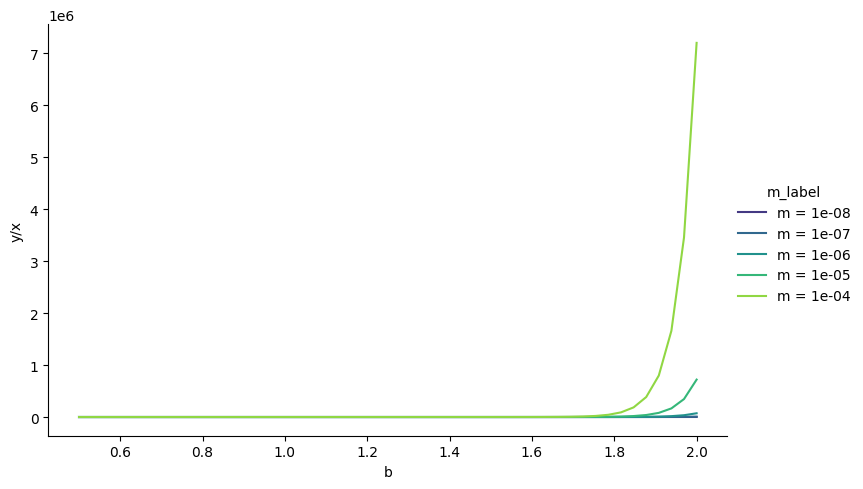

In [11]:
tp.tee(
    sns.relplot,
    data=df,
    x="b",
    y="y/x",
    hue="m_label",
    kind="line",
    aspect=1.5,
    height=5,
    palette="viridis",
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={"what": "mutant-ratio-vs-b-log", "T": T},
)
plt.axvline(x=1.0, color="gray", linestyle="--", alpha=0.5, label="b=1")
plt.yscale("log")
plt.xlabel("Relative Growth Rate (b)")
plt.ylabel("Mutant Ratio (y/x)")
plt.title(f"Mutant Ratio at T={T} Doublings (Log Scale)");


## Time Evolution of Mutant Ratio


In [12]:
# Time evolution for different b values
t_range = np.linspace(0, 25, 100)
b_selected = np.array([0.8, 0.9, 1.0, 1.1, 1.2])
m_fixed = 1e-6

records_time = []
for b in b_selected:
    ratios = calc_mutant_ratio(t_range, np.array([b]), m_fixed)
    for i, t in enumerate(t_range):
        records_time.append({
            "t": t,
            "b": b,
            "y/x": ratios[i, 0],
            "b_label": f"b = {b:.1f}",
        })

df_time = pd.DataFrame(records_time)


teeplots/2025-02-04-mutant-ratio-derivation/hue=b-label+kind=line+m=1e-06+palette=coolwarm+viz=relplot+what=mutant-ratio-vs-time+x=t+y=y-x+ext=.pdf
teeplots/2025-02-04-mutant-ratio-derivation/hue=b-label+kind=line+m=1e-06+palette=coolwarm+viz=relplot+what=mutant-ratio-vs-time+x=t+y=y-x+ext=.png


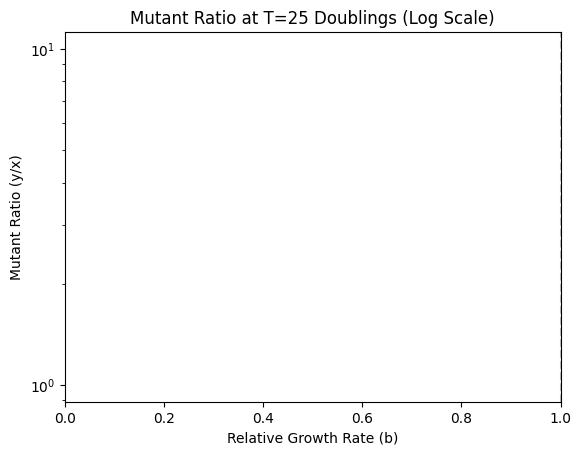

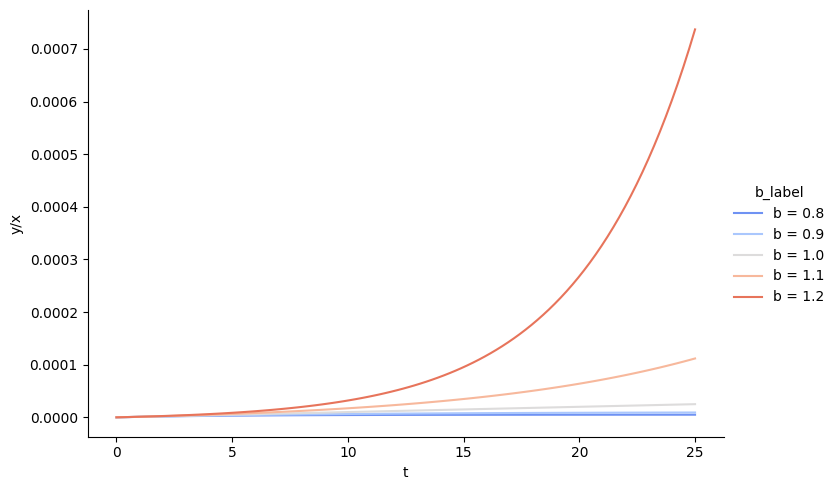

In [13]:
tp.tee(
    sns.relplot,
    data=df_time,
    x="t",
    y="y/x",
    hue="b_label",
    kind="line",
    aspect=1.5,
    height=5,
    palette="coolwarm",
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={"what": "mutant-ratio-vs-time", "m": m_fixed},
)
plt.xlabel("Time (doublings)")
plt.ylabel("Mutant Ratio (y/x)")
plt.title(f"Mutant Ratio Over Time (m={m_fixed:.0e})");


teeplots/2025-02-04-mutant-ratio-derivation/hue=b-label+kind=line+m=1e-06+palette=coolwarm+viz=relplot+what=mutant-ratio-vs-time-log+x=t+y=y-x+ext=.pdf
teeplots/2025-02-04-mutant-ratio-derivation/hue=b-label+kind=line+m=1e-06+palette=coolwarm+viz=relplot+what=mutant-ratio-vs-time-log+x=t+y=y-x+ext=.png


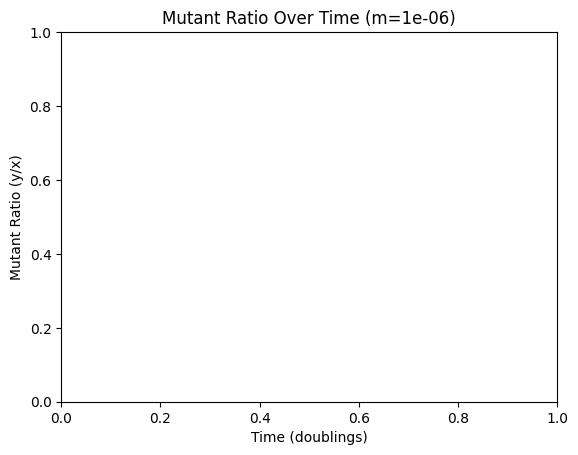

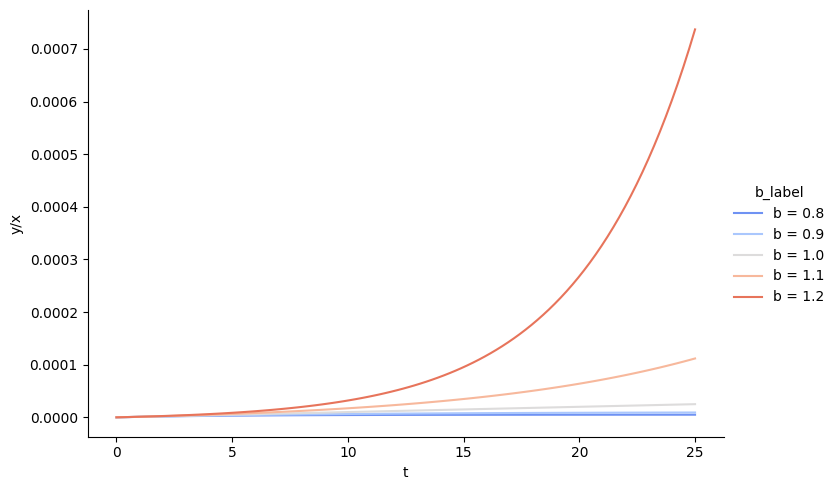

In [14]:
tp.tee(
    sns.relplot,
    data=df_time,
    x="t",
    y="y/x",
    hue="b_label",
    kind="line",
    aspect=1.5,
    height=5,
    palette="coolwarm",
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={"what": "mutant-ratio-vs-time-log", "m": m_fixed},
)
plt.yscale("log")
plt.xlabel("Time (doublings)")
plt.ylabel("Mutant Ratio (y/x)")
plt.title(f"Mutant Ratio Over Time (m={m_fixed:.0e}, Log Scale)");


## Summary Table


In [15]:
# Create summary table for specific parameter combinations
m_table = np.array([1e-8, 1e-7, 1e-6, 1e-5, 1e-4])
b_table = np.array([0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0])
T_table = 25

# Calculate ratios for all combinations
table_data = {}
for m in m_table:
    ratios = calc_mutant_ratio(np.array([T_table]), b_table, m)
    table_data[f"m={m:.0e}"] = ratios[0, :]

summary_df = pd.DataFrame(table_data, index=[f"b={b:.1f}" for b in b_table])
summary_df.index.name = "Growth Rate"

# Format values as scientific notation for display
print(f"Mutant Ratio (y/x) at T={T_table} Doublings")
display(summary_df.applymap(lambda x: f"{x:.2e}"))


Mutant Ratio (y/x) at T=25 Doublings


/tmp/ipykernel_4683/2678096878.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(summary_df.applymap(lambda x: f"{x:.2e}"))


,m=1e-08,m=1e-07,m=1e-06,m=1e-05,m=1e-04
Growth Rate,,,,,
b=0.8,4.97e-08,4.97e-07,4.97e-06,4.97e-05,4.97e-04
b=0.9,9.18e-08,9.18e-07,9.18e-06,9.18e-05,9.18e-04
b=1.0,2.50e-07,2.50e-06,2.50e-05,2.50e-04,2.50e-03
b=1.1,1.12e-06,1.12e-05,1.12e-04,1.12e-03,1.12e-02
b=1.2,7.37e-06,7.37e-05,7.37e-04,7.37e-03,7.37e-02
b=1.5,5.37e-03,5.37e-02,5.37e-01,5.37e+00,5.37e+01
b=2.0,7.20e+02,7.20e+03,7.20e+04,7.20e+05,7.20e+06


## Heatmap Visualization


In [16]:
# Create heatmap data
m_heat = np.logspace(-8, -4, 20)
b_heat = np.linspace(0.5, 2.0, 20)
T_heat = 25

# Build matrix
heat_matrix = np.zeros((len(b_heat), len(m_heat)))
for j, m in enumerate(m_heat):
    ratios = calc_mutant_ratio(np.array([T_heat]), b_heat, m)
    heat_matrix[:, j] = ratios[0, :]

heat_df = pd.DataFrame(
    heat_matrix,
    index=[f"{b:.2f}" for b in b_heat],
    columns=[f"{m:.1e}" for m in m_heat],
)


teeplots/2025-02-04-mutant-ratio-derivation/T=25+cmap=viridis+viz=heatmap+what=mutant-ratio-heatmap+ext=.pdf
teeplots/2025-02-04-mutant-ratio-derivation/T=25+cmap=viridis+viz=heatmap+what=mutant-ratio-heatmap+ext=.png


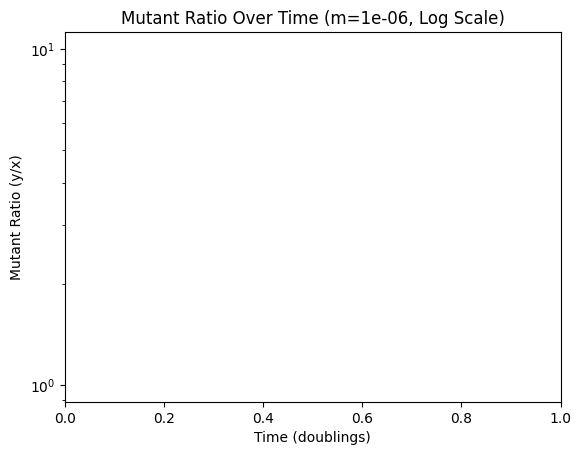

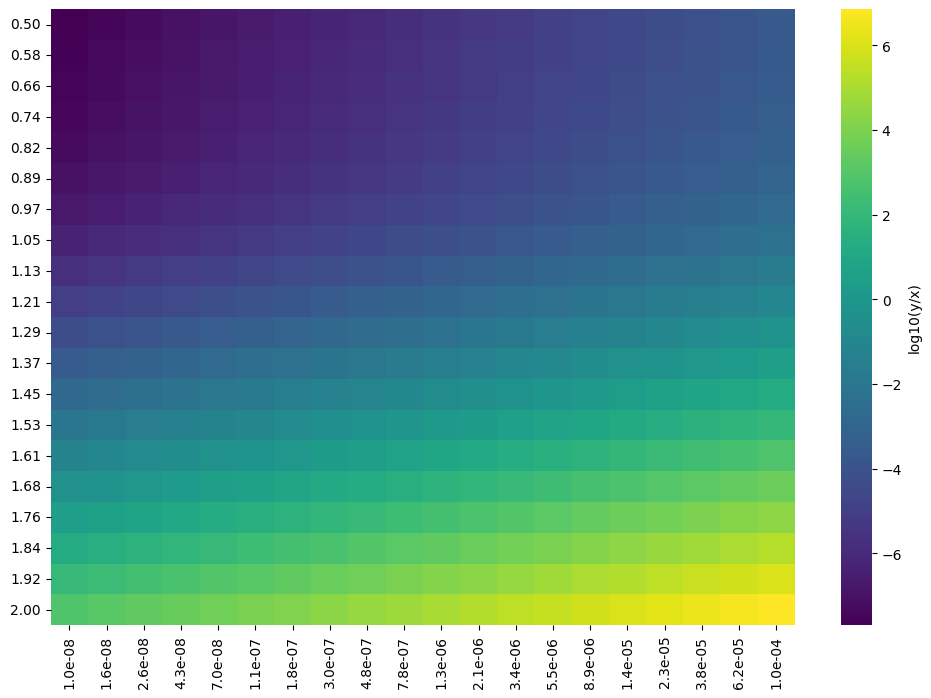

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
tp.tee(
    sns.heatmap,
    data=np.log10(heat_df.astype(float)),
    cmap="viridis",
    ax=ax,
    cbar_kws={"label": "log10(y/x)"},
    teeplot_subdir=teeplot_subdir,
    teeplot_outattrs={"what": "mutant-ratio-heatmap", "T": T_heat},
)
ax.set_xlabel("Mutation Rate (m)")
ax.set_ylabel("Relative Growth Rate (b)")
ax.set_title(f"log10(Mutant Ratio) at T={T_heat} Doublings")
plt.xticks(rotation=45, ha="right")
plt.tight_layout();
